In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import numpy as np
from scipy import ndimage

Result Plots

In [3]:
n_classes_SIC = 12
LABELS_SIC = {
    0: 0,
    1: 10,
    2: 20,
    3: 30,
    4: 40,
    5: 50,
    6: 60,
    7: 70,
    8: 80,
    9: 90,
    10: 100
}
CLABEL_SIC = 'Sea Ice Concentration [%]'

def cbar_ice_classification(ax, n_classes, LABELS, CBAR_LABEL, cmap='viridis'):
    arranged = np.arange(0, n_classes)
    cmap = plt.get_cmap(cmap, n_classes - 1)
    norm = mpl.colors.BoundaryNorm(arranged - 0.5, cmap.N)
    arranged = arranged[:-1]  # Discount the mask class.
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                        ticks=arranged, fraction=0.0485, pad=0.049, ax=ax)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(label=CBAR_LABEL, fontsize=12)
    cbar.set_ticklabels(list(LABELS.values()))

def diff_plot(ax, scene1, scene2, title1, title2):
    ax.set_title("Differences between \n" + title1 + " and \n" + title2)
    diff = np.abs(np.subtract(scene1, scene2))
    im = ax.imshow(diff, cmap='hot_r')
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(label='Difference', fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])

In [5]:
def boundary_mask(seg, dilation_radius=15):
    """
    Returns a boolean mask where boundaries between classes (including np.nan) are True,
    and non-boundary elements are False. The boundary is widened by 'dilation_radius'.
    """
    mask = np.zeros_like(seg, dtype=bool)
    # Get unique non-nan classes
    classes = np.unique(seg[~np.isnan(seg)])
    has_nan = np.isnan(seg).any()

    for cls in classes:
        class_mask = (seg == cls)
        sx = ndimage.sobel(class_mask.astype(float), axis=0, mode='constant')
        sy = ndimage.sobel(class_mask.astype(float), axis=1, mode='constant')
        magnitude = np.hypot(sx, sy)
        mask |= magnitude > 0

    if has_nan:
        nan_mask = np.isnan(seg)
        sx = ndimage.sobel(nan_mask.astype(float), axis=0, mode='constant')
        sy = ndimage.sobel(nan_mask.astype(float), axis=1, mode='constant')
        magnitude = np.hypot(sx, sy)
        mask |= magnitude > 0

    # Dilation to widen the boundary
    structure = ndimage.generate_binary_structure(2, 2)  # 8-connectivity
    mask = ndimage.binary_dilation(mask, structure=structure, iterations=dilation_radius)
    return mask

def matrixflip(m, d):
    tempm = m.copy()

    if d == 'h':
        #for row in tempm:
        #    row.reverse()
        tempm = np.fliplr(tempm)
    elif d == 'v':
        #tempm.reverse()
        tempm = np.flipud(tempm)
    elif d == 'c90':
        tempm = [list(row) for row in zip(*reversed(tempm))]  # Rotate 90 degrees clockwise

    return tempm

def cbar_classification(ax, LABELS, CBAR_LABEL, cmap, bins):
    norm = mpl.colors.BoundaryNorm(boundaries=bins, ncolors=len(bins)-1)

    # Compute tick positions at the center of each bin range
    tick_positions = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]

    # Create the colorbar
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                        ticks=tick_positions, fraction=0.0485, pad=0.049, ax=ax)

    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(label=CBAR_LABEL, fontsize=12)

    # Assign labels to the tick positions
    cbar.set_ticklabels([LABELS[b] for b in bins[:-1]])


def temperature_categories(data):
  temp_range = np.unique(data)
  discrete_temps = [234,235,237,239,240,242,244,245,247,249,250,252,254,255,257,259,260,262,264,265,267,269,271,273]

  for i in range(0,len(temp_range)):
    if temp_range[i] not in discrete_temps:
      closest_temp = (np.absolute(discrete_temps - temp_range[i])).argmin()

      indices = np.where(data == temp_range[i])
      np.put(data, indices, discrete_temps[closest_temp])

  return data




20210214T212045_dmi_prep.nc
20210214T212045_dmi_data


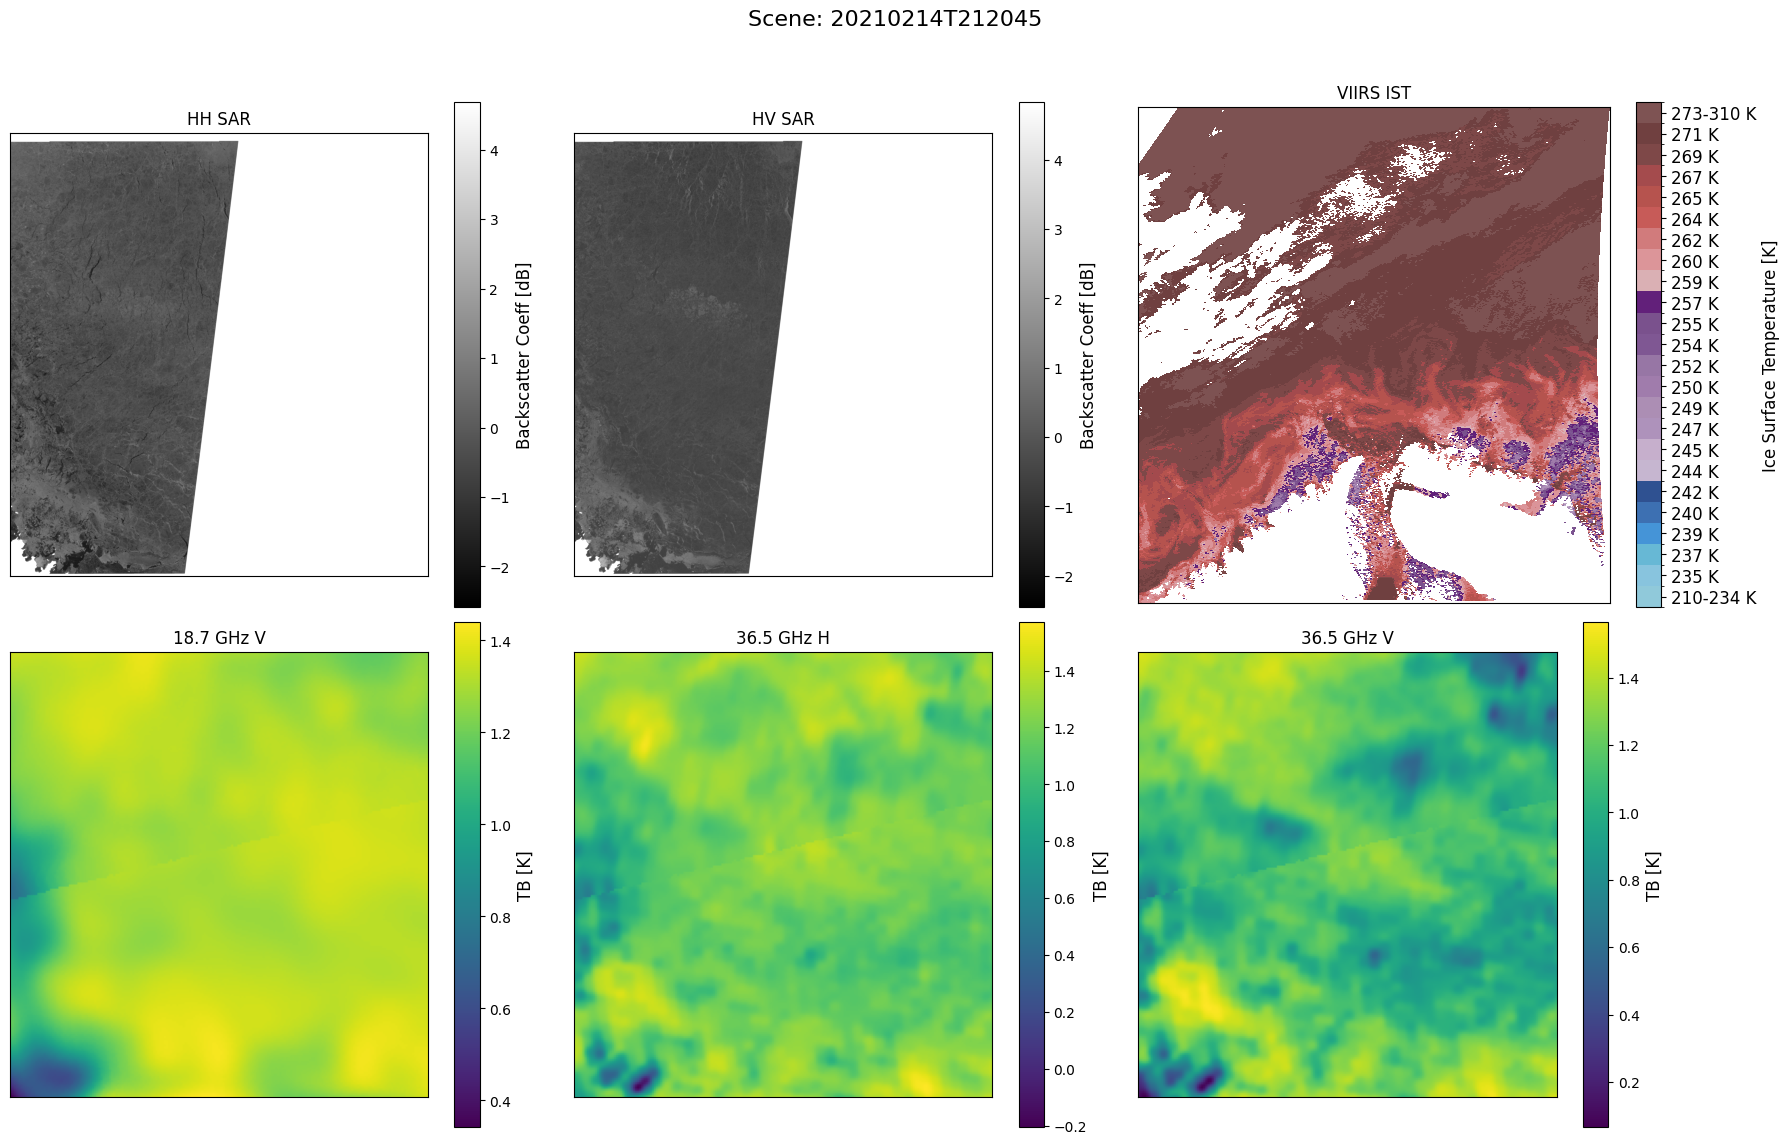

20210214T212045_dmi_results


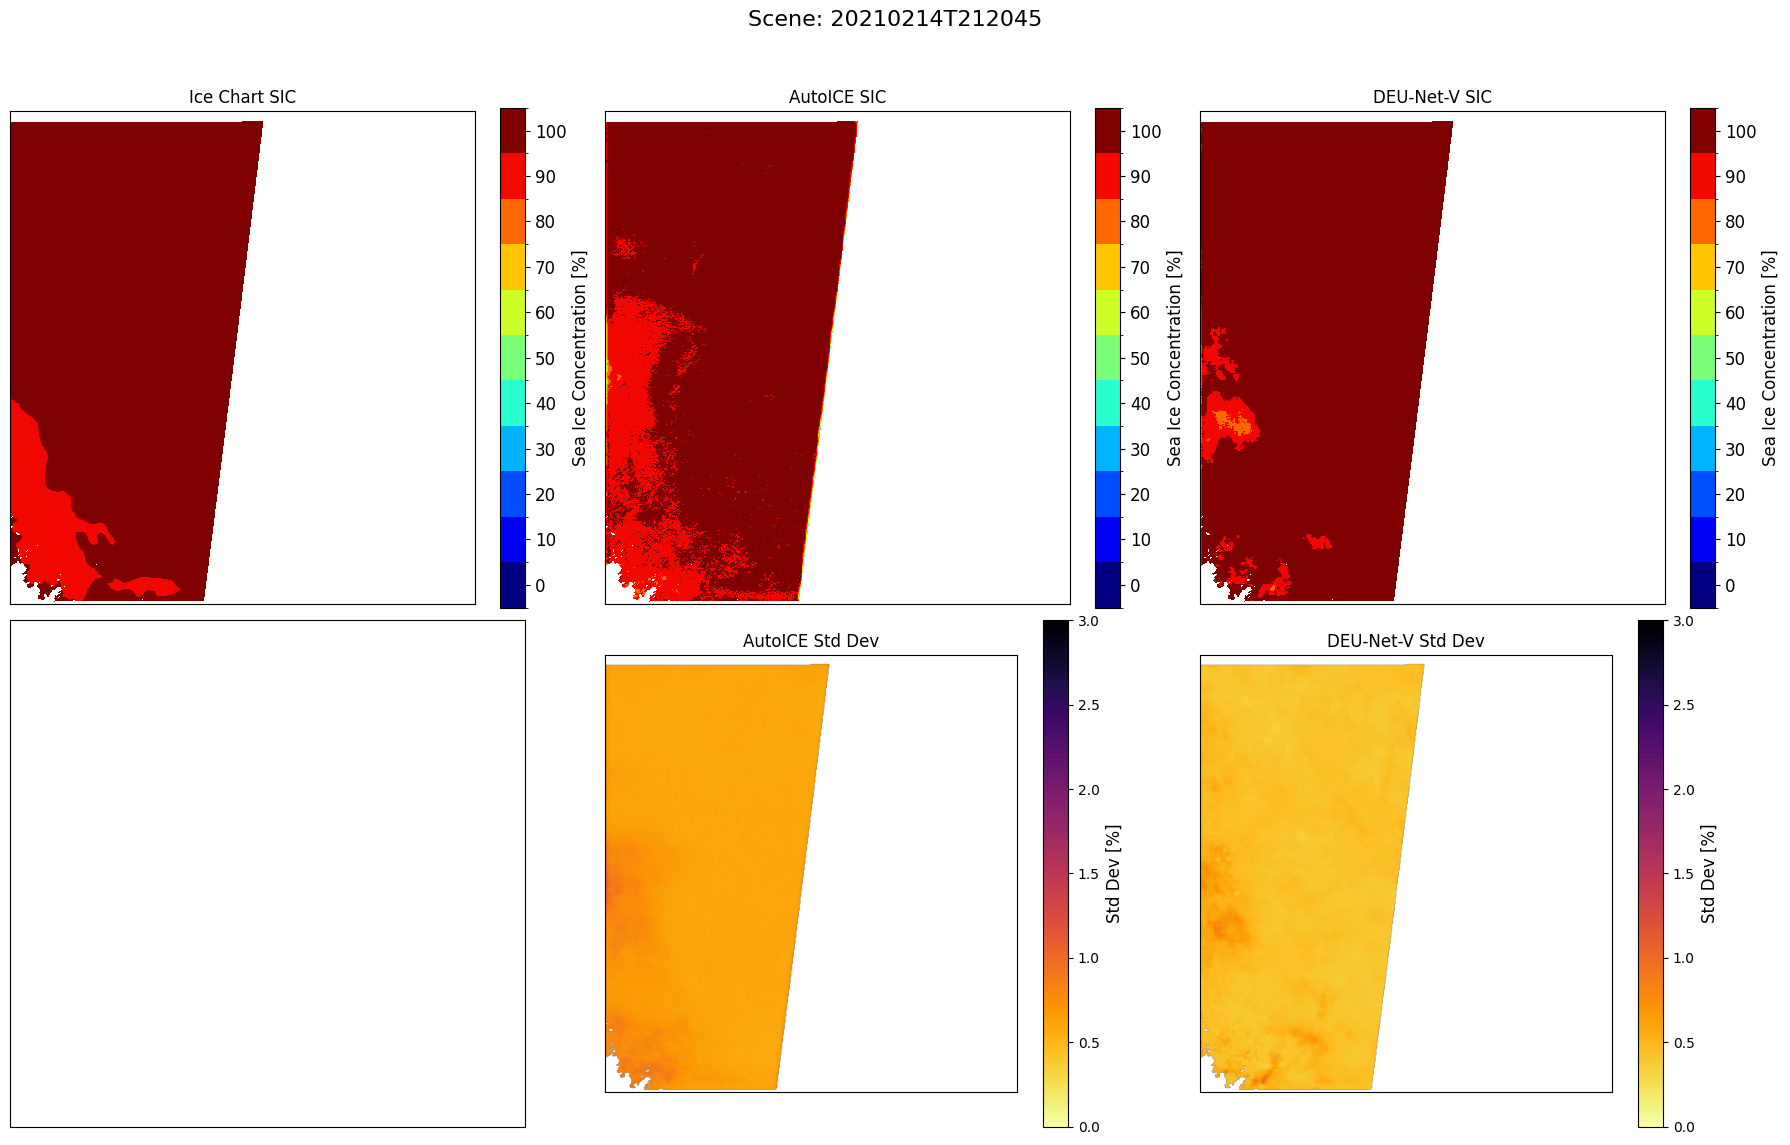

In [6]:
colours = [
        (0.5647, 0.7882, 0.8549), (0.5333, 0.7686, 0.8706), (0.4039, 0.7216, 0.8353),
        (0.2706, 0.5804, 0.8431), (0.2392, 0.4392, 0.6980), (0.1843, 0.3176, 0.5686),
        (0.7765, 0.7137, 0.8157), (0.7765, 0.6863, 0.8000), (0.6824, 0.5725, 0.7333),
        (0.6745, 0.5569, 0.7059), (0.6275, 0.4863, 0.6745), (0.5922, 0.4627, 0.6471),
        (0.4980, 0.3412, 0.5765), (0.4784, 0.3176, 0.5529), (0.3843, 0.1255, 0.4784),
        (0.8549, 0.6902, 0.7059), (0.8627, 0.5843, 0.6000), (0.8196, 0.4824, 0.4863),
        (0.7804, 0.3569, 0.3451), (0.7137, 0.3255, 0.3059), (0.6431, 0.2941, 0.3020),
        (0.4941, 0.2824, 0.2824), (0.4392, 0.2510, 0.2510), (0.4922, 0.3242, 0.3242)
    ]

labels = {
        234: '210-234 K', 235: '235 K', 237: '237 K', 239: '239 K', 240: '240 K',
        242: '242 K', 244: '244 K', 245: '245 K', 247: '247 K', 249: '249 K',
        250: '250 K', 252: '252 K', 254: '254 K', 255: '255 K', 257: '257 K',
        259: '259 K', 260: '260 K', 262: '262 K', 264: '264 K', 265: '265 K',
        267: '267 K', 269: '269 K', 271: '271 K', 273: '273-310 K'
    }

    # Extend bins by adding a final boundary at 310
bins = list(labels.keys()) + [310]

def diff_correct_predictions_two(ax1, ax2, scene1, scene2, chart, n_classes, LABELS, CLABEL, title1, title2):
    diff_scene_mask = (scene1 == scene2)
    scene1[diff_scene_mask] = np.nan
    scene2[diff_scene_mask] = np.nan


    scene1_chart_mask = scene1 != chart
    scene2_chart_mask = scene2 != chart


    scene1[scene1_chart_mask] = np.nan
    scene2[scene2_chart_mask] = np.nan


    ax1.set_title(title1)
    im1 = ax1.imshow(scene1, vmin=0, vmax=n_classes - 2, cmap='jet', interpolation='nearest')
    ax1.set_xticks([])
    ax1.set_yticks([])
    cbar_ice_classification(ax=ax1, n_classes=n_classes, LABELS=LABELS, CBAR_LABEL=CLABEL, cmap='jet')

    ax2.set_title(title2)
    im2 = ax2.imshow(scene2, vmin=0, vmax=n_classes - 2, cmap='jet', interpolation='nearest')
    ax2.set_xticks([])
    ax2.set_yticks([])
    cbar_ice_classification(ax=ax2, n_classes=n_classes, LABELS=LABELS, CBAR_LABEL=CLABEL, cmap='jet')

def plot_uncertainty_results_two(scene1, scene2, chart, chart_variable, scene_variable, n_classes, LABELS, CLABEL, scene1_title, scene2_title, chart_title, title, ist, reflect):
    chart_data = chart.variables[chart_variable].values
    mask = chart_data == 255
    chart_mask = mask

    chart_data = chart_data.astype(float)
    chart_data[mask] = np.nan
    chart_data = matrixflip(chart_data.tolist(),reflect)

    data1 = scene1.variables[scene_variable + '_SIC'].values
    data1 = data1.astype(float)
    data1[data1 >= 11] = 10
    data1[mask] = np.nan
    data1 = matrixflip(data1.tolist(),reflect)

    data2 = scene2.variables[scene_variable + '_SIC'].values
    data2 = data2.astype(float)
    data2[data2 >= 11] = 10
    data2[mask] = np.nan
    data2 = matrixflip(data2.tolist(),reflect)

    print(scene_variable + '_data')

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(title, fontsize=16)

    # SAR HH
    sar = chart.variables['nersc_sar_primary'].values
    sar = sar.astype(float)
    sar[mask] = np.nan
    sar = matrixflip(sar.tolist(),reflect)

    ax = axes[0, 0]
    ax.set_title('HH SAR')
    im = ax.imshow(sar, cmap='gray')
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(label='Backscatter Coeff [dB]', fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])

    # SAR HV
    sar = chart.variables['nersc_sar_secondary'].values
    sar = sar.astype(float)
    sar[mask] = np.nan
    sar = matrixflip(sar.tolist(),reflect)

    ax = axes[0, 1]
    ax.set_title('HV SAR')
    im = ax.imshow(sar, cmap='gray')
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(label='Backscatter Coeff [dB]', fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])

    # IST
    ax = axes[0, 2]
    cmap = mpl.colors.ListedColormap(colours[:len(bins)-1])  # Match bins

    ist_data = ist.variables['IST'].values
    mask = ist_data < 200
    ist_shape = ist_data.shape
    ist_flat = temperature_categories(np.round(ist_data.astype(float).flatten()))
    ist_data = ist_flat.reshape(ist_shape)
    ist_data[mask] = np.nan
    ist_data = matrixflip(ist_data.tolist(),reflect)

    ax.set_title('VIIRS IST')
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot the data
    im = ax.imshow(ist_data, cmap=cmap, interpolation='nearest', norm=mpl.colors.BoundaryNorm(bins, cmap.N))
    # Create colorbar with full range
    cbar_classification(ax, labels, 'Ice Surface Temperature [K]', cmap, bins)

    mask = chart_mask

    # AMSR 18.7 v
    amsr = chart.variables['btemp_18_7v'].values
    amsr = matrixflip(amsr.tolist(),reflect)

    ax = axes[1, 0]
    ax.set_title('18.7 GHz V')
    im = ax.imshow(amsr)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(label='TB [K]', fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])

    # AMSR 36.5 h
    amsr = chart.variables['btemp_36_5h'].values
    amsr = matrixflip(amsr.tolist(),reflect)

    ax = axes[1, 1]
    ax.set_title('36.5 GHz H')
    im = ax.imshow(amsr)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(label='TB [K]', fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])

    # AMSR 36.5 v
    amsr = chart.variables['btemp_36_5v'].values
    amsr = matrixflip(amsr.tolist(),reflect)

    ax = axes[1, 2]
    ax.set_title('36.5 GHz V')
    im = ax.imshow(amsr)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(label='TB [K]', fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('/content/drive/MyDrive/Uncertainty-Comparison/' + scene_variable + '_data_' + scene1_title.split(" ")[0] + '_' + scene2_title.split(" ")[0] + '.png')
    plt.show()

    print(scene_variable + '_results')

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(title, fontsize=16)

    # Chart data
    ax = axes[0, 0]
    ax.set_title(chart_title)
    im = ax.imshow(chart_data, vmin=0, vmax=n_classes - 2, cmap='jet', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    cbar_ice_classification(ax=ax, n_classes=n_classes, LABELS=LABELS, CBAR_LABEL=CLABEL, cmap='jet')

    # Scene 1
    ax = axes[0, 1]
    ax.set_title(scene1_title + ' SIC')
    im = ax.imshow(data1, vmin=0, vmax=n_classes - 2, cmap='jet', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    cbar_ice_classification(ax=ax, n_classes=n_classes, LABELS=LABELS, CBAR_LABEL=CLABEL, cmap='jet')

    # Scene 2
    ax = axes[0, 2]
    ax.set_title(scene2_title + ' SIC')
    im = ax.imshow(data2, vmin=0, vmax=n_classes - 2, cmap='jet', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    cbar_ice_classification(ax=ax, n_classes=n_classes, LABELS=LABELS, CBAR_LABEL=CLABEL, cmap='jet')

    std_dev1 = scene1.variables[scene_variable + '_STD_DEV'].values
    std_dev1 = std_dev1.astype(float)
    std_dev1[mask] = np.nan
    std_dev1 = matrixflip(std_dev1.tolist(),reflect)


    std_dev2 = scene2.variables[scene_variable + '_STD_DEV'].values
    std_dev2 = std_dev2.astype(float)
    std_dev2[mask] = np.nan
    std_dev2 = matrixflip(std_dev2.tolist(),reflect)


    ax = axes[1, 0]
    ax.set_xticks([])
    ax.set_yticks([])

    # VAR 1
    ax = axes[1, 1]
    ax.set_title(scene1_title + ' Std Dev')
    im = ax.imshow(std_dev1, vmin=0, vmax=3, cmap='inferno_r')
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(label='Std Dev [%]', fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])

    # VAR 2
    ax = axes[1, 2]
    ax.set_title(scene2_title + ' Std Dev')
    im = ax.imshow(std_dev2, vmin=0, vmax=3, cmap='inferno_r')
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(label='Std Dev [%]', fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('/content/drive/MyDrive/Uncertainty-Comparison/' + scene_variable + '_predictions_' + scene1_title.split(" ")[0] + '_' + scene2_title.split(" ")[0] + '.png')
    plt.show()


def plot_uncertainty(scene1, scene2, chart, chart_variable, scene_variable, n_classes, LABELS, CLABEL, scene1_title, scene2_title, chart_title, title, ist, reflect):
    chart_data = chart.variables[chart_variable].values
    mask = chart_data == 255

    chart_data = chart_data.astype(float)
    chart_data[mask] = np.nan

    data1 = scene1.variables[scene_variable + '_SIC'].values
    data1 = data1.astype(float)
    data1[data1 >= 11] = 10
    data1[mask] = np.nan

    data2 = scene2.variables[scene_variable + '_SIC'].values
    data2 = data2.astype(float)
    data2[data2 >= 11] = 10
    data2[mask] = np.nan

    print(scene_variable + '_results')

    std_dev1 = scene1.variables[scene_variable + '_STD_DEV'].values
    std_dev1 = std_dev1.astype(float)
    std_dev1[mask] = np.nan


    std_dev2 = scene2.variables[scene_variable + '_STD_DEV'].values
    std_dev2 = std_dev2.astype(float)
    std_dev2[mask] = np.nan

    b_mask = boundary_mask(chart_data)

    ##
    data1 = matrixflip(data1.tolist(),reflect)
    data1 = np.array(data1)
    data2 = matrixflip(data2.tolist(),reflect)
    data2 = np.array(data2)

    chart_data = matrixflip(chart_data.tolist(),reflect)
    chart_data = np.array(chart_data)

    b_mask = matrixflip(b_mask.tolist(),reflect)
    b_mask = np.array(b_mask)

    std_dev1 = matrixflip(std_dev1.tolist(),reflect)
    std_dev1 = np.array(std_dev1)

    std_dev2 = matrixflip(std_dev2.tolist(),reflect)
    std_dev2 = np.array(std_dev2)

    ##

    polygon_boundaries1 = std_dev1.copy().astype(float)
    polygon_boundaries1[~b_mask] = np.nan
    polygon_centers1 = std_dev1.copy().astype(float)
    polygon_centers1[b_mask] = np.nan

    polygon_boundaries2 = std_dev2.copy().astype(float)
    polygon_boundaries2[~b_mask] = np.nan
    polygon_centers2 = std_dev2.copy().astype(float)
    polygon_centers2[b_mask] = np.nan

    data = data1.copy().astype(float)
    data[b_mask] = np.nan
    datab1 = data

    data = data2.copy().astype(float)
    data[b_mask] = np.nan
    datab2 = data

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Scene: ' + scene_variable + ' with Boundaries', fontsize=16)

    ax = axes[0,0]
    im = ax.imshow(datab1, vmin=0, vmax=n_classes_SIC - 2, cmap='jet', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    cbar_ice_classification(ax=ax, n_classes=n_classes_SIC, LABELS=LABELS_SIC, CBAR_LABEL=CLABEL_SIC, cmap='jet')

    ax = axes[0,1]
    im = ax.imshow(polygon_boundaries1, cmap='inferno_r', vmin=0, vmax=3)
    cbar = plt.colorbar(im, ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])
    cbar.set_label(label=' Standard Deviation: Polygon Boundaries [%]', fontsize=12)

    ax = axes[0,2]
    im = ax.imshow(polygon_centers1, cmap='inferno_r', vmin=0, vmax=3)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(label='Standard Deviation: Polygon Centers [%]', fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])

    ax = axes[1,0]
    im = ax.imshow(datab2, vmin=0, vmax=n_classes_SIC - 2, cmap='jet', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    cbar_ice_classification(ax=ax, n_classes=n_classes_SIC, LABELS=LABELS_SIC, CBAR_LABEL=CLABEL_SIC, cmap='jet')

    ax = axes[1,1]
    im = ax.imshow(polygon_boundaries2, cmap='inferno_r', vmin=0, vmax=3)
    cbar = plt.colorbar(im, ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])
    cbar.set_label(label=' Standard Deviation: Polygon Boundaries [%]', fontsize=12)

    ax = axes[1,2]
    im = ax.imshow(polygon_centers2, cmap='inferno_r', vmin=0, vmax=3)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(label='Standard Deviation: Polygon Centers [%]', fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('/content/drive/MyDrive/Uncertainty-Comparison/' + scene_variable + '_boundaries_' + scene1_title.split(" ")[0] + '_' + scene2_title.split(" ")[0] + '.png')
    plt.show()

    print(scene_variable + '_comparison')

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(title, fontsize=16)

    # Differences CHART SCENE 1
    diff_plot(axes[1, 0], chart_data, data1, chart_title, scene1_title)
    # Differences CHART SCENE 2
    diff_plot(axes[1, 1], chart_data, data2, chart_title, scene2_title)

    # Differences SCENES 1-2
    diff_plot(axes[1, 2], data1, data2, scene1_title, scene2_title)


    # Correct predictions for each scene
    diff_correct_predictions_two(axes[0, 0], axes[0, 1], data1, data2, chart_data, n_classes, LABELS, CLABEL,
                             "Only Correct For: \n" + scene1_title, "Only Correct For: \n" + scene2_title)

    # Diff VAR 1-2
    diff_plot(axes[0, 2], std_dev1, std_dev2, scene1_title + ' Std Dev', scene2_title + ' Std Dev')


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('/content/drive/MyDrive/Uncertainty-Comparison/' + scene_variable + '_comparison_' + scene1_title.split(" ")[0] + '_' + scene2_title.split(" ")[0] + '.png')
    plt.show()



ice_chart_path = '/content/drive/MyDrive/Compare-Results/Charts/'
ice_chart = [file for file in os.listdir(ice_chart_path) if file.endswith(".nc")]
viirs = [file for file in os.listdir('/content/drive/MyDrive/Compare-Results/VIIRS/') if file.endswith(".nc")]
orientation = ['h','na','h','h','h','h','c90','h','h','v','c90','na']
scene_path = '/content/'
scene1 = ['AutoICE.nc'] # weight 0 for you
scene2 = ['DEU-Net-V.nc'] # weight 50 for you

i=6 #back for 1, 6

for idx in range(0,len(scene1)):
  scene1_name = scene1[idx].split(".nc")[0] # change based on your naming convention
  scene2_name = scene2[idx].split(".nc")[0] # change based on your naming convention

  chart_name = "Ice Chart"

  scene1_data = xr.open_dataset(scene_path + scene1[idx])
  scene2_data = xr.open_dataset(scene_path + scene2[idx])


  for chart in ice_chart:
    chart = ice_chart[i]
    print(chart)
    reflect = orientation[i]
    ist = viirs[i]

    scene_id = chart.split("_")[0]
    chart_data = xr.open_dataset(ice_chart_path + chart)
    scene_variable = chart.split("_prep")[0]

    ist_data = xr.open_dataset('/content/drive/MyDrive/Compare-Results/VIIRS/' + ist)

    ### Separated in case of OOM issues ###
    # first two plots (data and results)
    plot_uncertainty_results_two(scene1_data, scene2_data, chart_data, "SIC", scene_variable, n_classes_SIC, LABELS_SIC, CLABEL_SIC, scene1_name, scene2_name, chart_name + " SIC", "Scene: " + scene_id, ist_data, reflect)
    # second two plots (boundaries and differences)
    #plot_uncertainty(scene1_data, scene2_data, chart_data, "SIC", scene_variable, n_classes_SIC, LABELS_SIC, CLABEL_SIC, scene1_name, scene2_name, chart_name + " SIC", "Scene: " + scene_id, ist_data, reflect)

    break

Box Plots

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import xarray as xr


# File paths
ice_chart_path = '/content/drive/MyDrive/Compare-Results/Charts/'
scene_path = '/content/'
ice_chart_files = [file for file in os.listdir(ice_chart_path) if file.endswith(".nc")]
scene1 = ['AutoICE.nc']  # change as needed

def load_data(file):
  for scene_file in file:
      with xr.open_dataset(os.path.join(scene_path, scene_file)) as scene_data:
          # Initialize per-class lists
          sic_std_dict = {cls: [] for cls in range(11)}

          for chart_file in ice_chart_files:
              with xr.open_dataset(os.path.join(ice_chart_path, chart_file)) as chart_data:
                  scene_variable = chart_file.split("_prep")[0]

                  # Load and mask SIC data
                  sic = chart_data['SIC'].values.astype(float)
                  sic[sic == 255] = np.nan

                  # Load corresponding std dev from model output
                  std_dev = scene_data[scene_variable + '_STD_DEV'].values.astype(float)
                  std_dev[np.isnan(sic)] = np.nan  # match NaN mask

                  # Filter and append to class-wise buckets
                  valid = ~np.isnan(sic) & ~np.isnan(std_dev)
                  sic_flat = sic[valid].astype(int).flatten()
                  std_flat = std_dev[valid].flatten()

                  for cls in range(11):
                      cls_mask = sic_flat == cls
                      if np.any(cls_mask):
                          sic_std_dict[cls].extend(std_flat[cls_mask].tolist())  # Use list.extend for efficiency
  return sic_std_dict


def plot_single_boxplot_per_class(sic_std_dict, title_prefix, max_points_per_class=10000):
    """
    Plots a separate boxplot for each SIC class, with mean and median annotated.

    Parameters:
        sic_std_dict (dict): Dictionary of standard deviations keyed by SIC class (int 0–10).
        title_prefix (str): Prefix for each plot title.
        max_points_per_class (int): Max number of points to plot per class for memory efficiency.
    """
    for cls in range(11):
        data = np.array(sic_std_dict[cls])

        if len(data) == 0:
            print(f"Skipping SIC class {cls}: no data.")
            continue

        if len(data) > max_points_per_class:
            data = np.random.choice(data, max_points_per_class, replace=False)

        mean_val = np.mean(data)

        plt.figure(figsize=(6, 6))
        bp = plt.boxplot(data, vert=True, tick_labels=[str(cls)])

        # Plot the mean as a red triangle
        plt.plot(1, mean_val, marker='^', color='red', markersize=8, label='Mean')

        # Create legend handles
        median_line = plt.Line2D([], [], color='orange', linestyle='-', label='Median')
        mean_marker = plt.Line2D([], [], color='red', marker='^', linestyle='None', label='Mean')

        plt.legend(handles=[median_line, mean_marker])

        plt.title(f"{title_prefix} {cls}")
        plt.ylabel("Aleatoric Uncertainty, Std Dev (σ)")
        plt.xlabel("Ground Truth SIC Class")
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig('/content/drive/MyDrive/Box-Plots/' + title_prefix + '_' + str(cls) + '.png')
        plt.show()


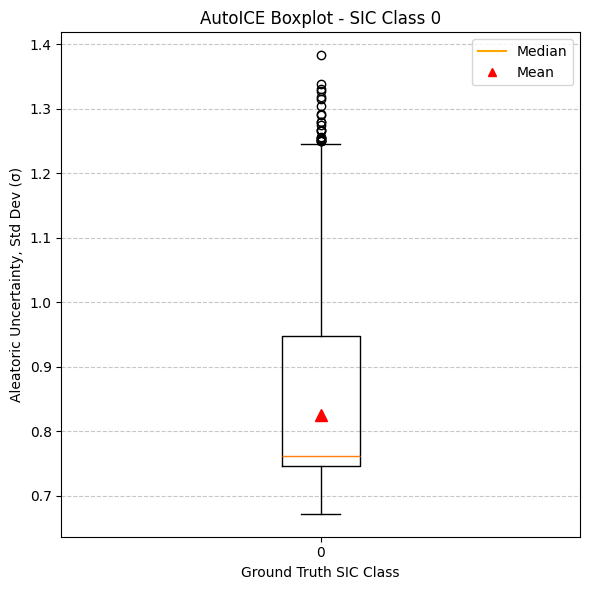

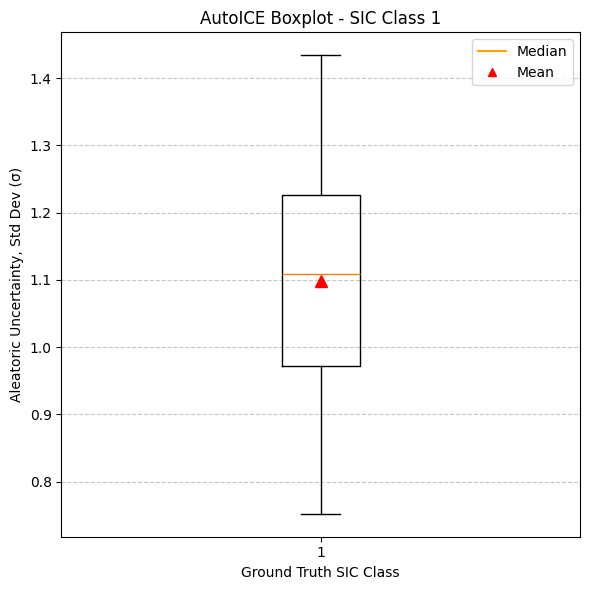

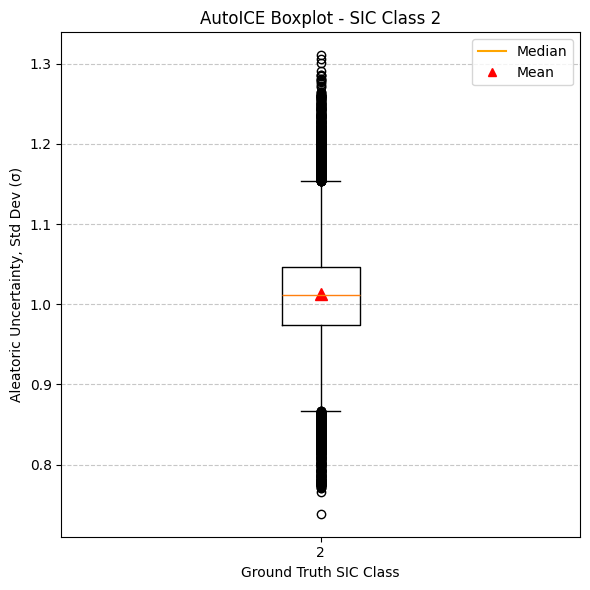

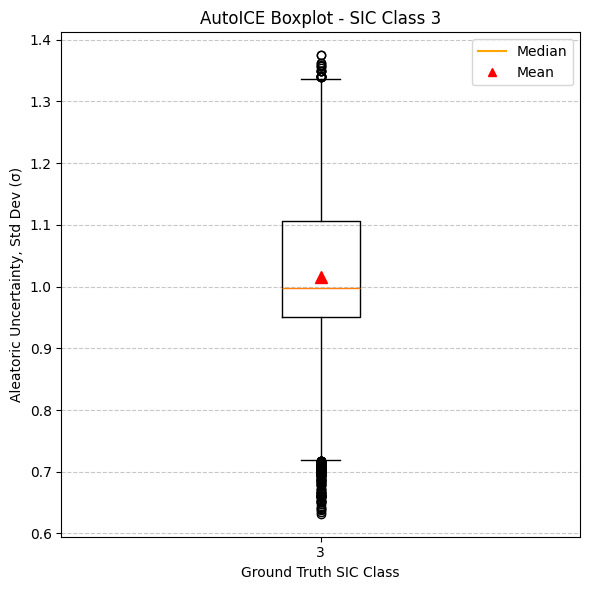

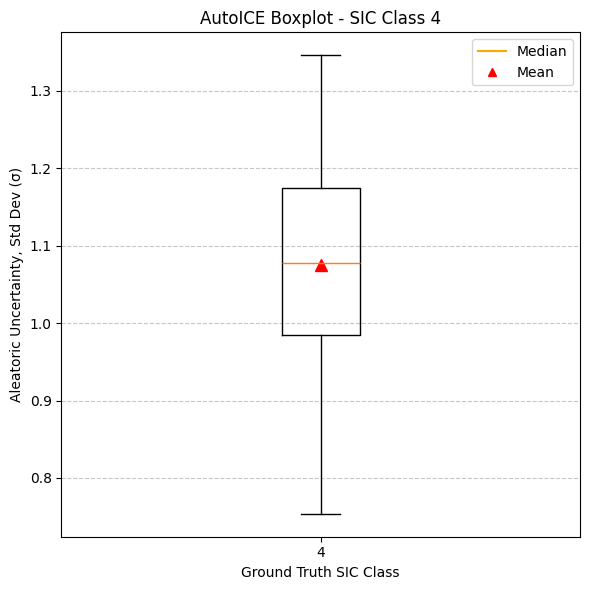

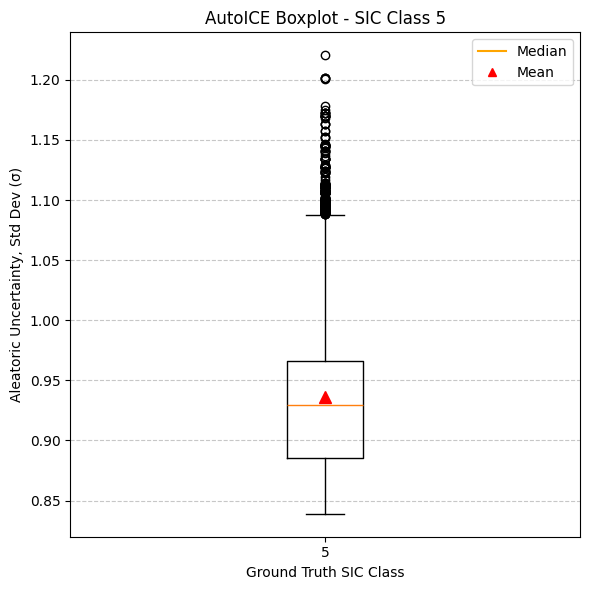

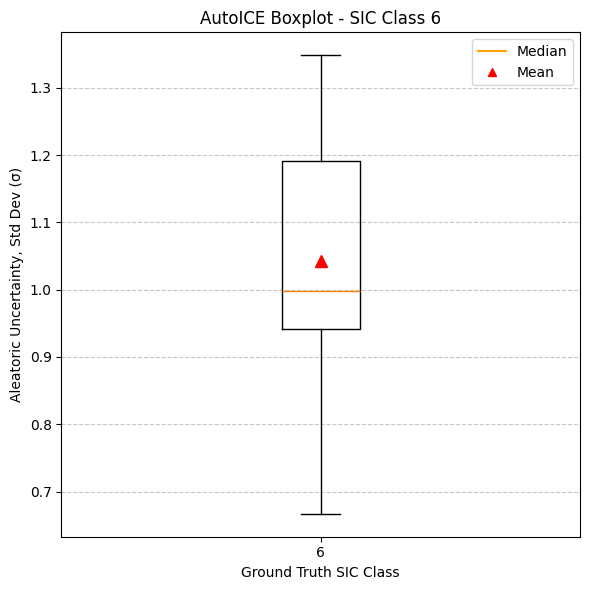

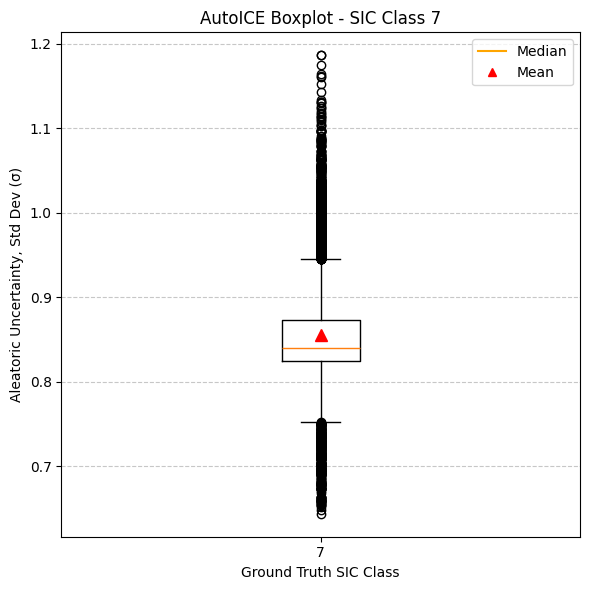

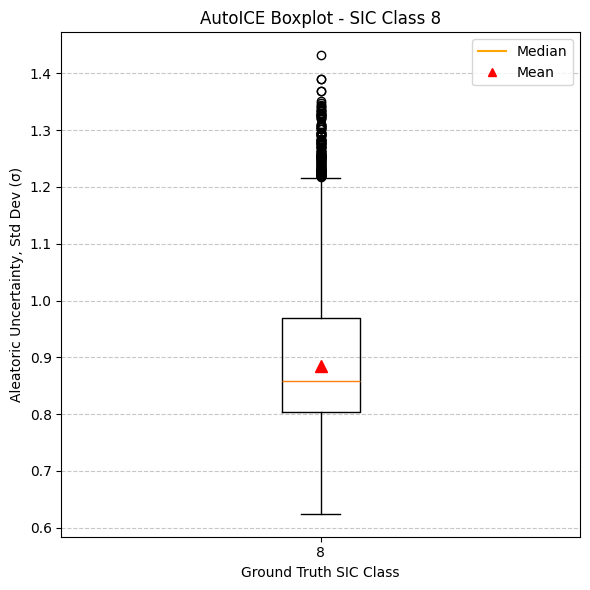

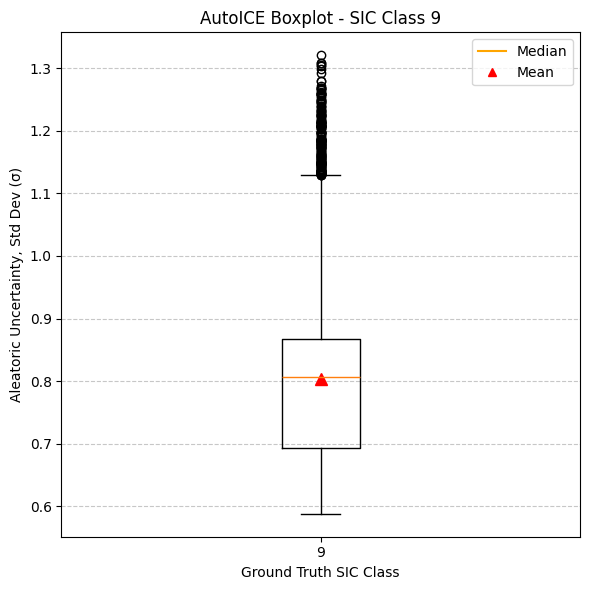

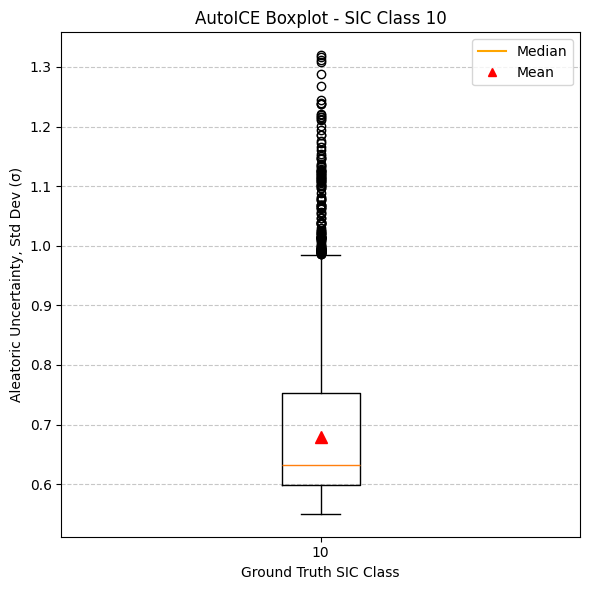

In [2]:
sic_std_dict = load_data(scene1)
boxplot_data = [np.array(sic_std_dict[cls]) for cls in range(11)]
plot_single_boxplot_per_class(boxplot_data, 'AutoICE Boxplot - SIC Class')

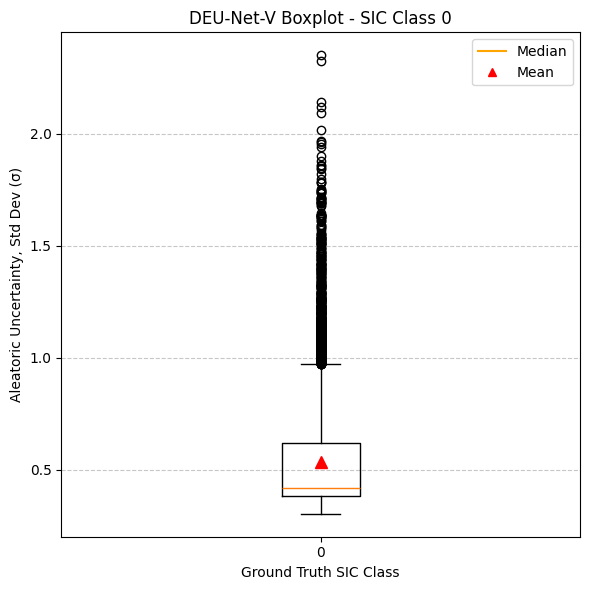

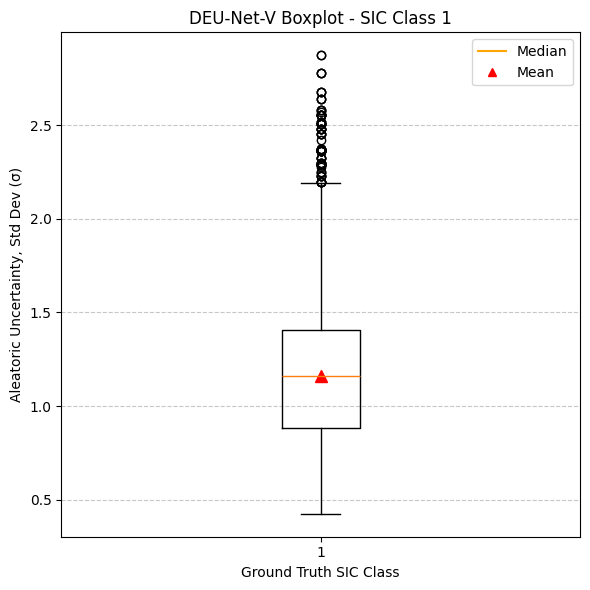

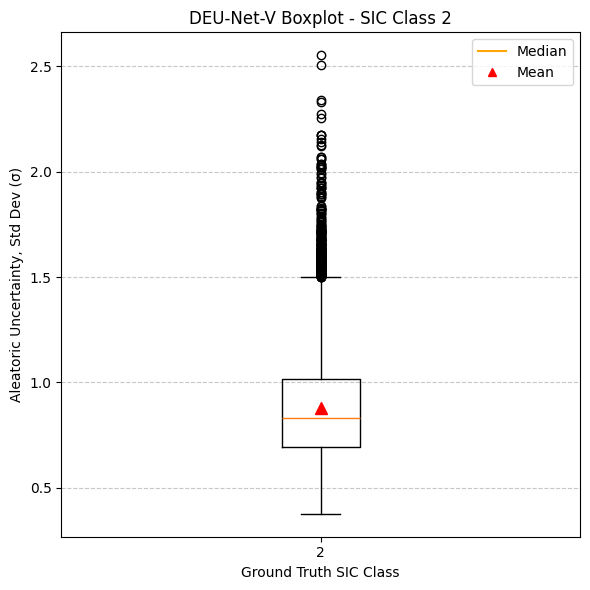

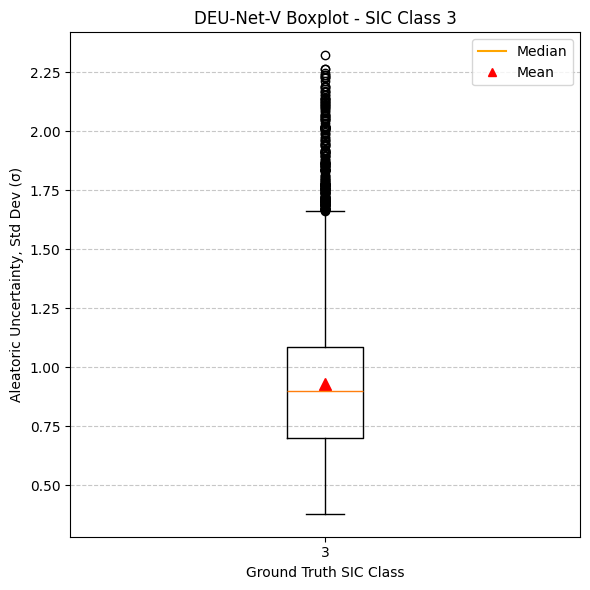

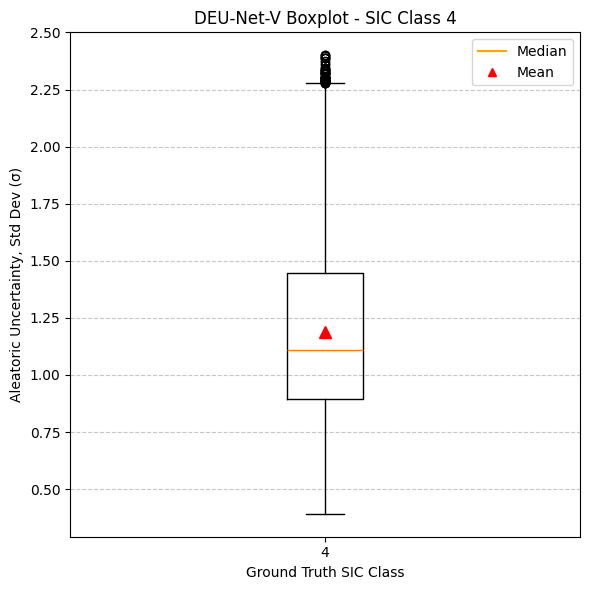

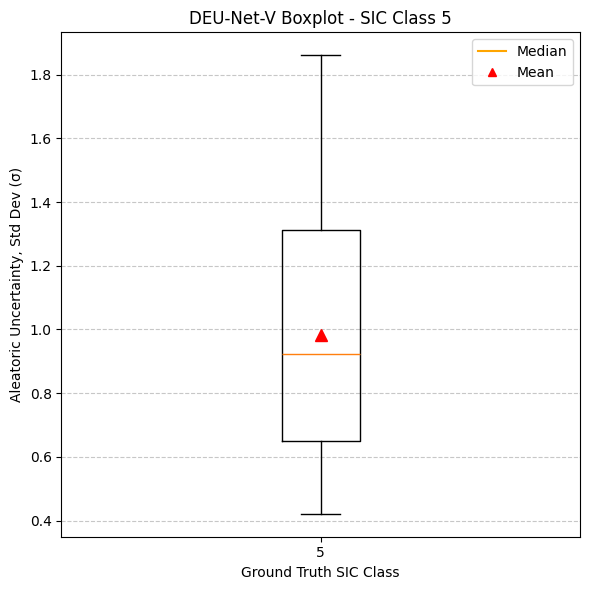

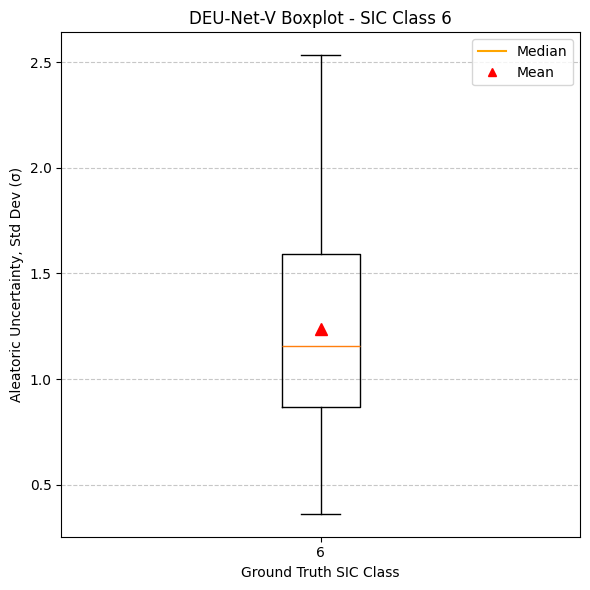

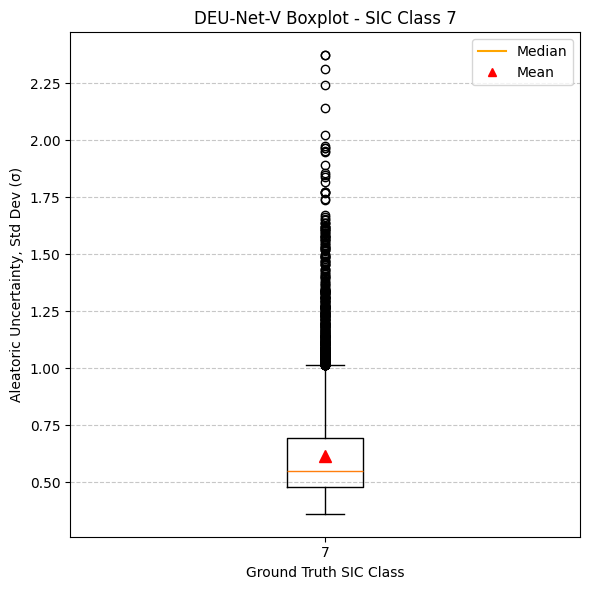

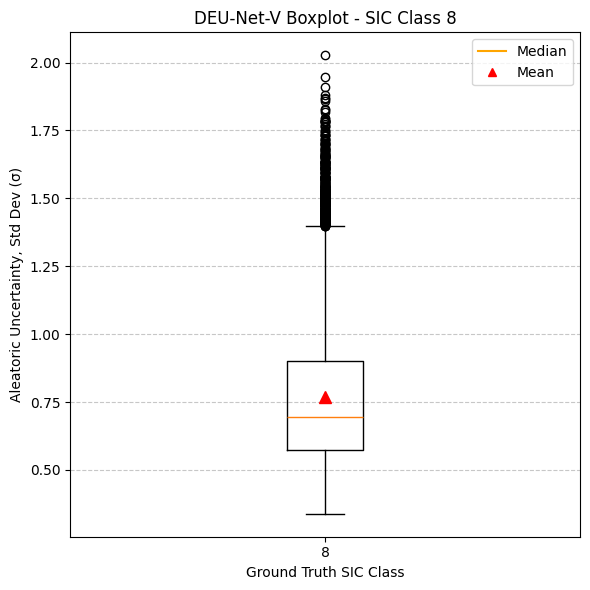

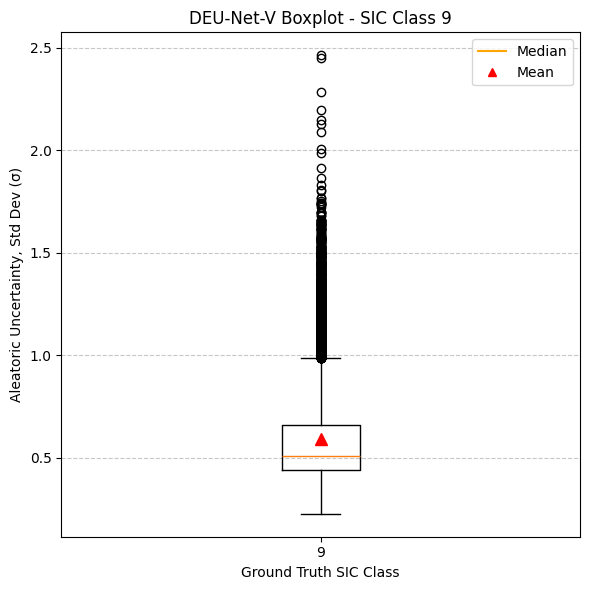

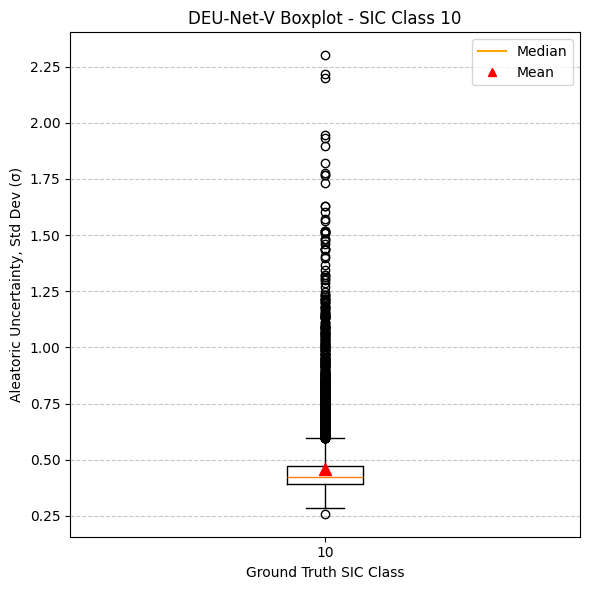

In [2]:
scene2 = ['DEU-Net-V.nc']  # change as needed

sic_std_dict = load_data(scene2)
boxplot_data = [np.array(sic_std_dict[cls]) for cls in range(11)]
plot_single_boxplot_per_class(boxplot_data, 'DEU-Net-V Boxplot - SIC Class')

CSV File

In [ ]:
import csv
ice_chart_path = '/content/drive/MyDrive/Compare-Results/Charts/'
ice_chart = [file for file in os.listdir(ice_chart_path) if file.endswith(".nc")]
scene_path = '/content/'
scene1 = ['AutoICE.nc'] # weight 0 for you
scene2 = ['DEU-Net-V.nc'] # weight 50 for you

with open('average_uncertainty_autoice_deu_net_v.csv', 'w', newline='') as csvfile:
  writer = csv.writer(csvfile)

  # Write the header row
  writer.writerow(['Scene', 'AutoICE', 'DEU-Net-V'])

  for idx in range(0,len(scene1)):
    scene1_name = scene1[idx].split(".nc")[0] # change based on your naming convention
    scene2_name = scene2[idx].split(".nc")[0] # change based on your naming convention

    chart_name = "Ice Chart"

    scene1_data = xr.open_dataset(scene_path + scene1[idx])
    scene2_data = xr.open_dataset(scene_path + scene2[idx])


    for chart in ice_chart:
      scene_id = chart.split("_")[0]
      chart_data1 = xr.open_dataset(ice_chart_path + chart)
      scene_variable = chart.split("_prep")[0]

      chart_data = chart_data1.variables['SIC'].values
      mask = chart_data == 255

      std_dev1 = scene1_data.variables[scene_variable + '_STD_DEV'].values
      std_dev1 = std_dev1.astype(float)
      std_dev1[mask] = np.nan

      std_dev2 = scene2_data.variables[scene_variable + '_STD_DEV'].values
      std_dev2 = std_dev2.astype(float)
      std_dev2[mask] = np.nan

      std_dev1_flat = std_dev1.flatten()
      cleaned_1 = std_dev1_flat[~np.isnan(std_dev1_flat)]
      std_dev2_flat = std_dev2.flatten()
      cleaned_2 = std_dev2_flat[~np.isnan(std_dev2_flat)]

      # Write the data row(s)
      writer.writerow([scene_variable, np.mean(cleaned_1), np.mean(cleaned_2)])